# YOBAPCA

An interactive Python notebook, demonstrating principal component analysis

In this demonstration, we are using popular Russian internet meme called "peka-face" (and also "yoba") to demonstrate application of dimensionality reduction to image data with highly repetetive patterns.

## 1. Allo yoba eto ti?

Here, let's import stuff, write couple helper functions and download the data

In [15]:
import os
import pathlib
import zipfile
from io import BytesIO
import random
import copy

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

from ipywidgets import widgets

In [16]:
plt.rcParams['figure.figsize'] = [12,12]
def yobadb_load(folder:str="./yobadb"):
    '''Load yoba pics from folder
    '''
    d = pathlib.Path(folder)
    yobas = [Image.open(d/f) for f in os.listdir(d)]
    return yobas

def yoabarchive_load(archive:str='./yobadb.zip'):
    '''Load yoba pics from archive
    '''
    with zipfile.ZipFile(archive, 'r') as zf:
        yobas = [Image.open(BytesIO(zf.read(f))) for f in zf.namelist()]
        return yobas

def preprocess_yobas(yobas:list, yobasize:int=512, dump:bool=False):
    '''Convert list of images to numpy array (n_pics x height x width x r x g x b)
    '''
    yobas = [np.asarray(yoba) for yoba in yobas] # now, let's convert all yobas to numpy arrays
    yobas = [yoba for yoba in yobas if yoba.shape == (yobasize, yobasize, 4)] #first, let's make sure that all yobas are of the same size
    yobas = np.array( yobas)
    yobas[np.where(yobas[:,:,:,-1] == 0)] = 255 # fill all transparent areas with white to remove artifacts
    yobas = yobas[:,:,:,:3] # remove alpha channel
    yobas = yobas / 255 # transform to 0-1
    if dump:
        yobas.dump('yobas.npy')
    return yobas

def yobadb_load_npy():
    yobas = np.load('./yobas.npy', allow_pickle=True)
    return yobas


Let's load yobas and also covert them to grayscale - it's more covnenient to start with 2d array

In [17]:
yobas = preprocess_yobas(yoabarchive_load())
yobas_grey = yobas.mean(axis=-1)

Here is a random yoba just for you

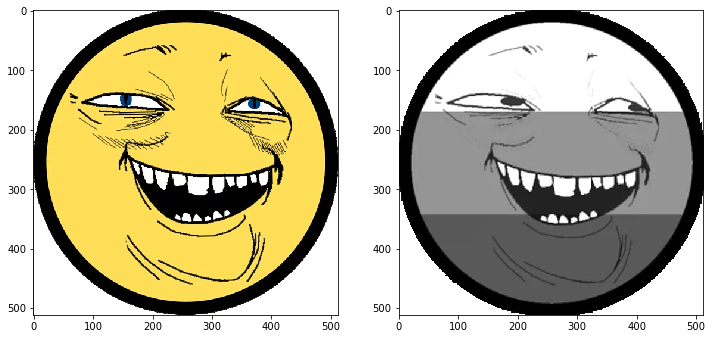

In [18]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(random.choice(yobas))
ax[1].imshow(random.choice(yobas_grey), cmap='gray');

## 2. Nyet, yoby net doma, eto peka

Okay, let's explore our dataset. We have 200 rare yobas pictures, 512x512 pixels each.
Now, let's look what an average yoba looks like!

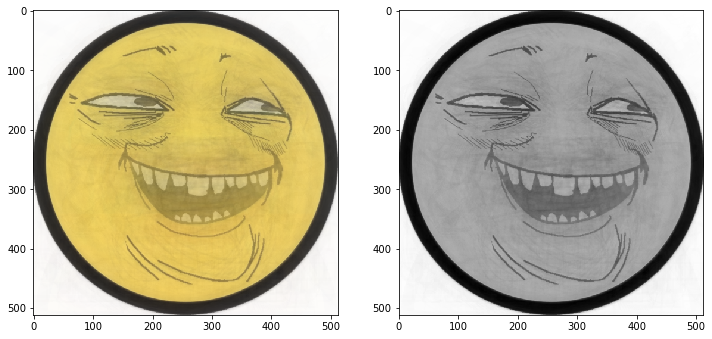

In [19]:
avg_yoba = yobas.mean(axis=0)
avg_gray_yoba = yobas_grey.mean(axis=0)

fig, ax = plt.subplots(1,2)
ax[0].imshow(avg_yoba)
ax[1].imshow(avg_gray_yoba, cmap='gray');

Now, let's flatten out pictures to fit in into PCA algorithm. C-like of Fortran-like order doesn't matter as long as it's consistent within array

In [25]:
flat_grey_yobas = yobas_grey.reshape(yobas_grey.shape[0], yobas_grey.shape[1]*yobas_grey.shape[2])
flat_yobas = yobas.reshape(yobas.shape[0], yobas.shape[1]*yobas.shape[2]*yobas.shape[3])

Now let's fit PCA 

In [26]:
pca = PCA()
gray_yobas_components = pca.fit_transform(flat_grey_yobas)

pca_c = PCA()
yobas_components = pca_c.fit_transform(flat_yobas)

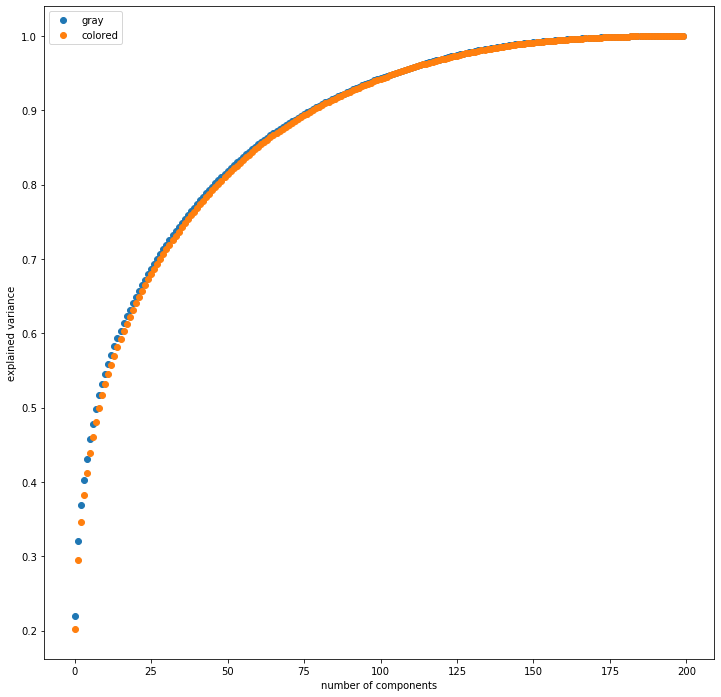

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o', label='gray')
plt.plot(np.cumsum(pca_c.explained_variance_ratio_), 'o', label='colored')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.legend();

Looks like you can preserve some information about structure of the image in just a few components. Let's check out the interactive demo:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


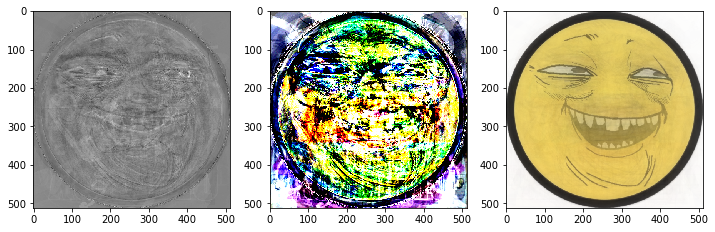

In [28]:
def draw(c=1):
    flat_yoba_n_components = pca_c.inverse_transform(yobas_components[:,c])
    flat_gray_yoba_n_components = pca.inverse_transform(gray_yobas_components[:,c])
    
    yoba_pic_gray = flat_gray_yoba_n_components.reshape(512, 512)
    yoba_pic_colored = flat_yoba_n_components.reshape(512, 512, 3)
    
    
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(yoba_pic_gray, cmap='gray')
    ax[1].imshow(yoba_pic_colored)
    ax[2].imshow(avg_yoba);
_ = widgets.interact(draw, c=(0, pca.n_components_-1, 1))